## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

### EDA

In [2]:
df = pd.read_csv(
    'HomeWork.csv',
    index_col=0,
)
df_copy = df.copy(deep=True)
df.head()

status  income   age        date
0    Student  4000.0  18.0  2022-01-23
1  Pensioner     NaN  91.0  2022-01-19
2    Student  4000.0  18.0  2022-01-03
3    Student     0.0   NaN  2022-01-13
4  Pensioner  5000.0  87.0  2022-01-31

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   status  490 non-null    object 
 1   income  430 non-null    float64
 2   age     441 non-null    float64
 3   date    500 non-null    object 
dtypes: float64(2), object(2)
memory usage: 19.5+ KB


In [4]:
df.describe()

income         age
count     430.000000  441.000000
mean   152020.623256   46.362812
std    242647.036978   25.036517
min    -13745.000000    0.000000
25%      2000.000000   23.000000
50%     21000.000000   44.000000
75%    217000.000000   68.000000
max    992000.000000   99.000000

In [5]:
df.describe(include = ['O'])

status        date
count       490         500
unique        4          32
top     Student  2022-01-11
freq        145          27

In [6]:
#Пропуски есть
df.isna().any().any()

True

Имеем два численных признака, один категориальный и дату. Наличие пропусков

### date

In [7]:
#приведем к удобному формату
df['date'] = pd.to_datetime(df['date'])

In [8]:
#диапазон времени
df['date'].min(), df['date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00'))

In [9]:
#отсутствие пропусков
df['date'].isna().sum()

0

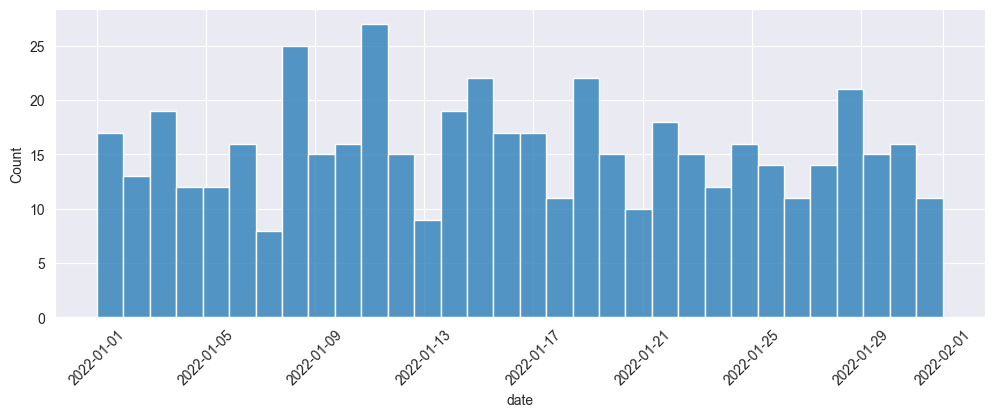

In [10]:
# зависимость кол-во "обращений" от дня
plt.figure(figsize=(12,4))
sns.histplot(data=df['date'],bins=32)

plt.xticks(rotation=45);

Общая картина в целом одинаковая. Явных аномалий нет

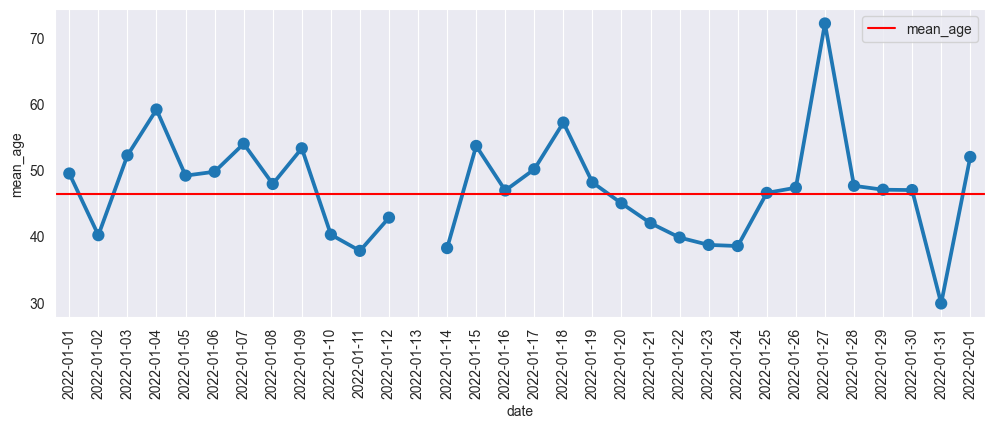

In [11]:
#зависимость среднего возраста от дня "обращения"
plt.figure(figsize=(12, 4))
df_new = df.resample('1d', on='date')['age'].mean().reset_index(name='mean_age')
df_new['date'] =  pd.to_datetime(df_new['date']).dt.date
sns.pointplot(data = df_new,x = 'date', y = 'mean_age')
plt.axhline (y=df['age'].mean(),color='red',label='mean_age')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

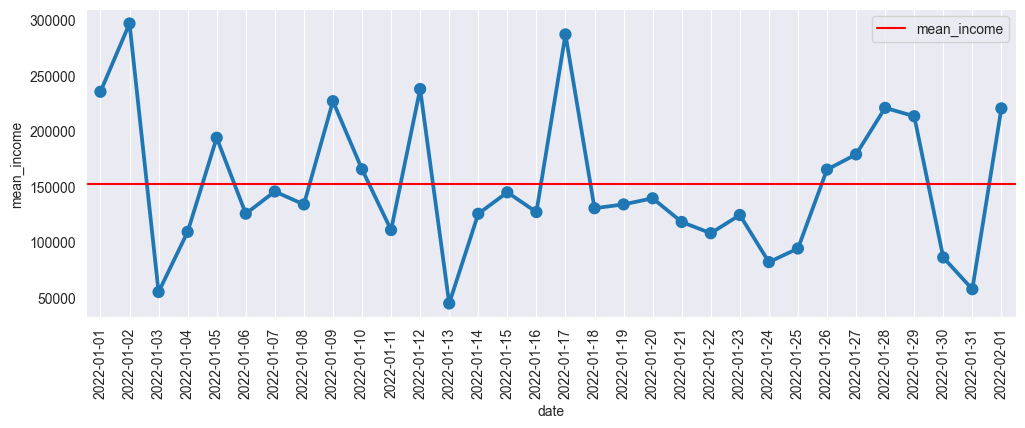

In [12]:
#зависимость среднего дохода  людей  от дня "обращения"
plt.figure(figsize=(12, 4))
df_new = df.resample('1d', on='date')['income'].mean().reset_index(name='mean_income')
df_new['date'] =  pd.to_datetime(df_new['date']).dt.date
sns.pointplot(data = df_new,x = 'date', y = 'mean_income')
plt.xticks(rotation=90)
plt.axhline (y=df['income'].mean(),color='red',label='mean_income')
plt.grid()
plt.legend()
plt.show()

### status

In [13]:
print(f' Пропусков: {df.status.isna().sum()/len(df) *100}%')

 Пропусков: 2.0%


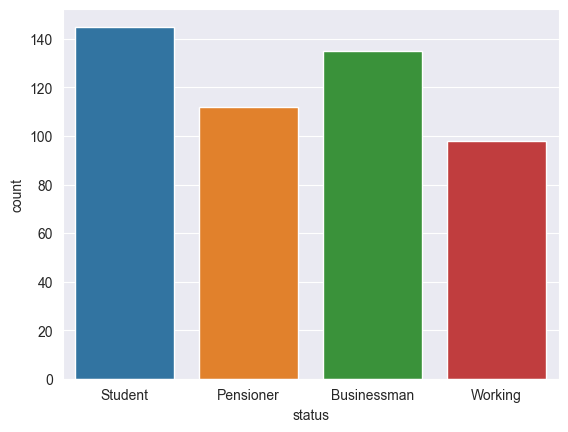

In [14]:
sns.countplot(data=df, x='status');

### income

In [15]:
print(f'Пропусков: {round(df.income.isna().sum()/len(df) *100,2)}%')
print(f'Нулевой доход имеют: {round(len(df.loc[df["income"] == 0])/len(df)*100,2)}%\
        \nОтрицательный доход имеют: {round(len(df.loc[df["income"] < 0])/len(df)*100,2)}%')

Пропусков: 14.0%
Нулевой доход имеют: 3.6%        
Отрицательный доход имеют: 11.8%


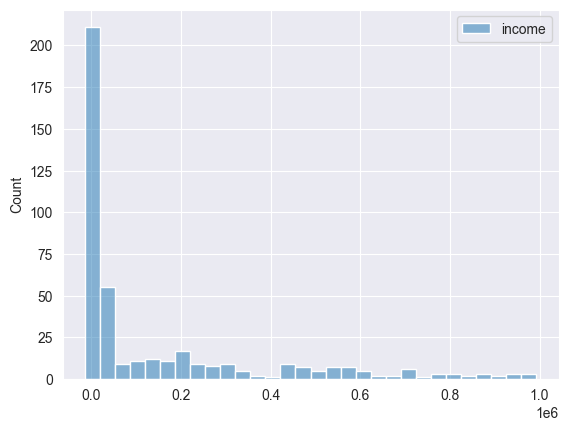

In [16]:
sns.histplot(df[['income']], bins=30);

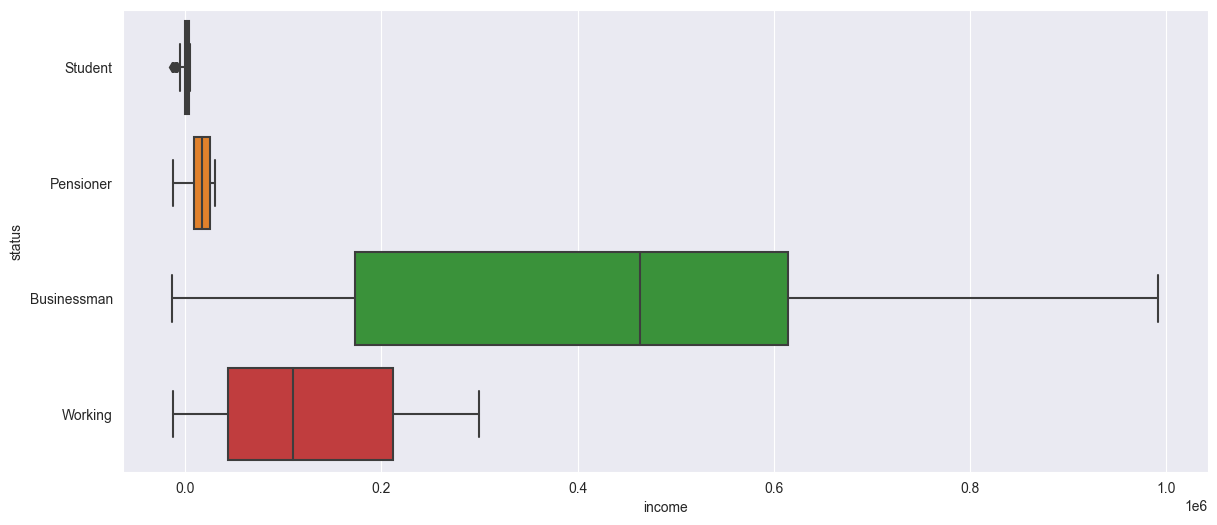

In [17]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='income', y='status');

Нулевой доход имеют только студенты - логично

In [18]:
df.loc[df['income'] == 0]['status'].unique()

array(['Student'], dtype=object)

Отрицательный доход  присутствует в каждой группе

In [19]:
df.loc[df['income'] < 0]['status'].value_counts()

Businessman    18
Working        16
Student        14
Pensioner      10
Name: status, dtype: int64

Средний доход бизнесменов больше всего, затем идет доход рабочих, пенсионеров,студентов - все логично 

### Age

In [20]:
print(f'Пропусков: {round(df.age.isna().sum()/len(df) *100,2)}%')

Пропусков: 11.8%


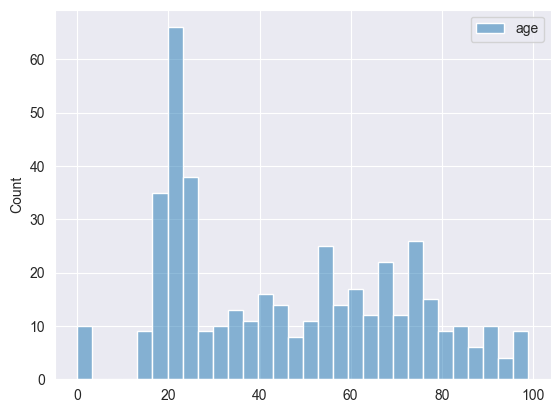

In [21]:
sns.histplot(df[['age']], bins=30);

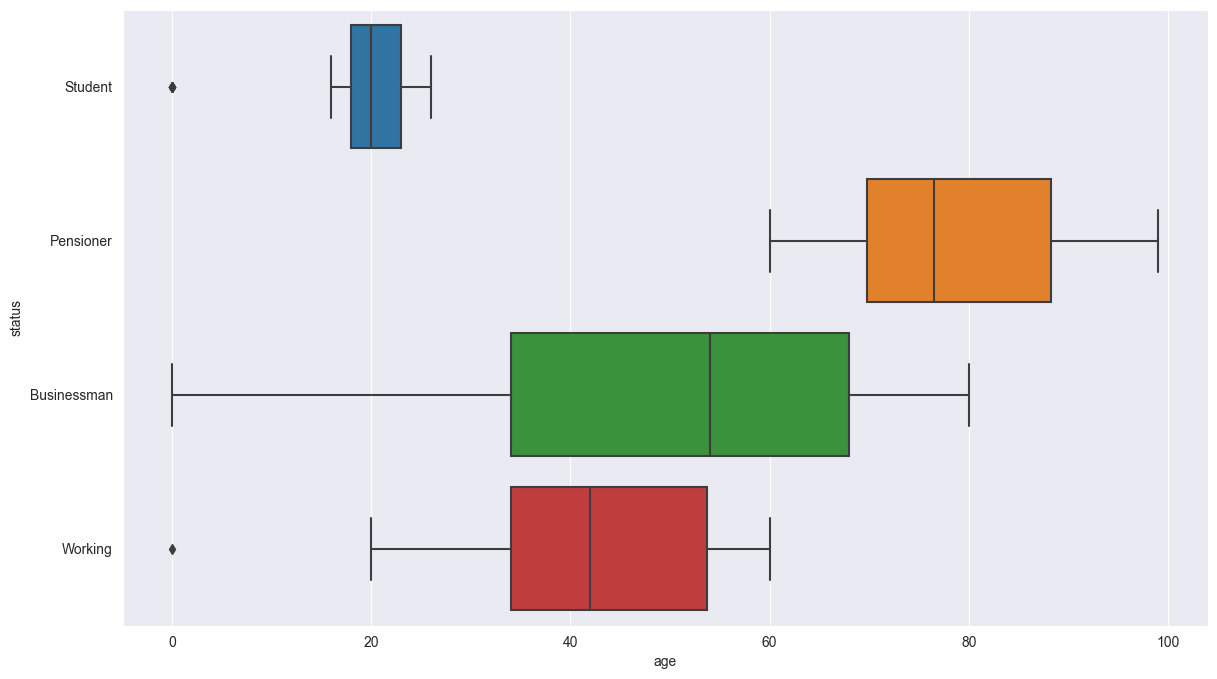

In [22]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='age', y='status');

In [23]:
print(f' Людей с нулевым  возрастом: {len(df["age"] == 0)/len(df)}%')

 Людей с нулевым  возрастом: 1.0%


## Выбросы

In [24]:
def get_outliers_info(df, d = 1.5):
    """
    Статистика по наличию выбросов в признаках.
    df - датасет с признаками 
    d - коэффициент, на который умножается IQR (обычно 1.5, что соотв. усам на boxplot)
    """
    df = df.copy()
    q75 = df.quantile(0.75)
    q25 = df.quantile(0.25)
    iqr = q75 - q25

    feature_list, outlier_list = [], []
    numerical_columns = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and df[c].nunique()>10]

    for feature in numerical_columns:
        lower_threshold = q25.loc[feature] - d*iqr[feature]
        upper_threshold = q75.loc[feature] + d*iqr[feature]
        
        df['is_outlier'] = np.nan
        df.loc[(df[feature] < lower_threshold) | (df[feature] > upper_threshold), 'is_outlier'] = 1
        df['is_outlier'] = df['is_outlier'].fillna(0)

        feature_list.append(feature)
        outlier_list.append(df['is_outlier'].mean())
        
    outliers_df = pd.DataFrame(index=feature_list, data=outlier_list, columns=['ratio_outliers'])
    outliers_df = outliers_df[outliers_df['ratio_outliers']>0]
    outliers_df = outliers_df.sort_values(by='ratio_outliers', ascending=False)
    
    return outliers_df

In [25]:
# Доля выбросов
outliers_df = get_outliers_info(df)
outliers_df.head()

ratio_outliers
income           0.088

Выбросы в **income**. Выведем данные

In [26]:
df = df.copy()
q75 = df.quantile(0.75)
q25 = df.quantile(0.25)
iqr = q75 - q25
upper_threshold = q75.loc['income'] + 1.5*iqr['income']
lower_threshold = q25.loc['income'] - 1.5*iqr['income']

#Доход выще upper_threshold
display(df.loc[(df["income"]>=upper_threshold )].groupby('status')['date'].count())

#Доход ниже lower_threshold - отсутствует
#display(df.loc[(df["income"]<lower_threshold )].groupby('status')['date'].count())

status
Businessman    43
Name: date, dtype: int64

Определили выбросы в  **income**, но эти выбросы -  правый хвост распределения  доходов бизнесменов. Логично, что у  бизнесменов могут быть и сверхдоходы. На данный момент я оставлю эти данные.

## Работа с пропусками

## income
Заполняем пропуски средним по статусу

In [27]:
def plot_feature_income(x):
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    df_new = df.loc[((df['status'] == x) & (~df['income'].isnull()))]
    plt.subplot(1, 2, 1);
    plt.title(f'{x} до заполнения пропусков')
    sns.distplot(df_new['income']);
    df.loc[((df['status'] == x) & (df['income'].isnull())), 'income'] = income_mean['Pensioner']
    plt.subplot(1, 2, 2)
    sns.distplot(df.loc[df['status']==x, 'income']);
    plt.title(f'{x} после заполнения пропусков');

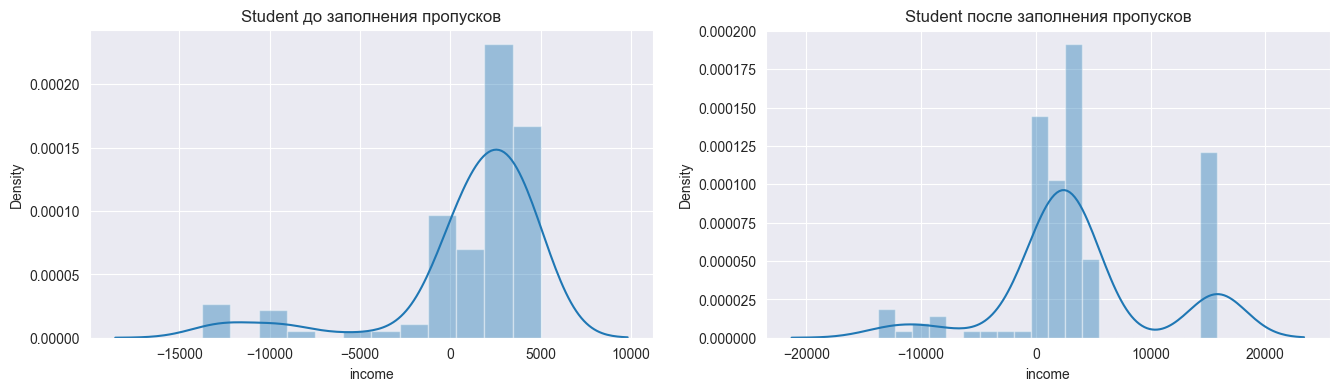

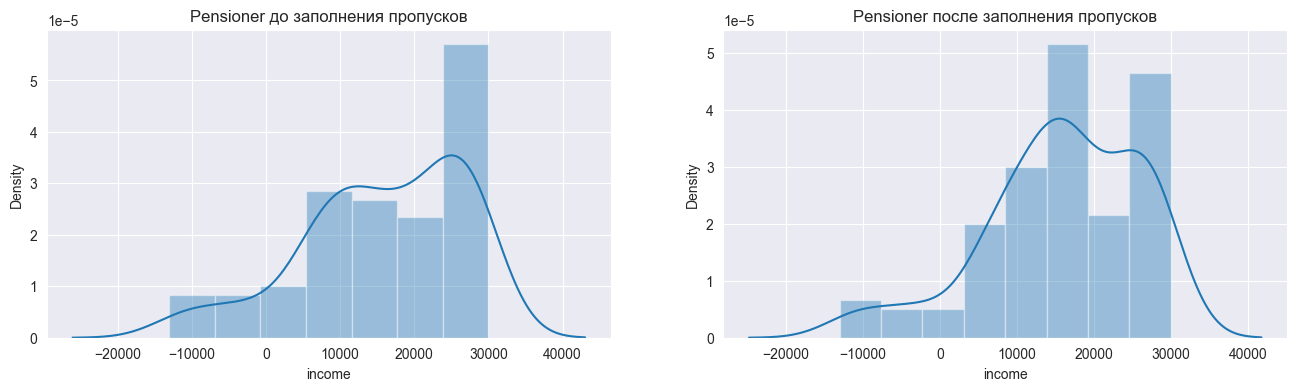

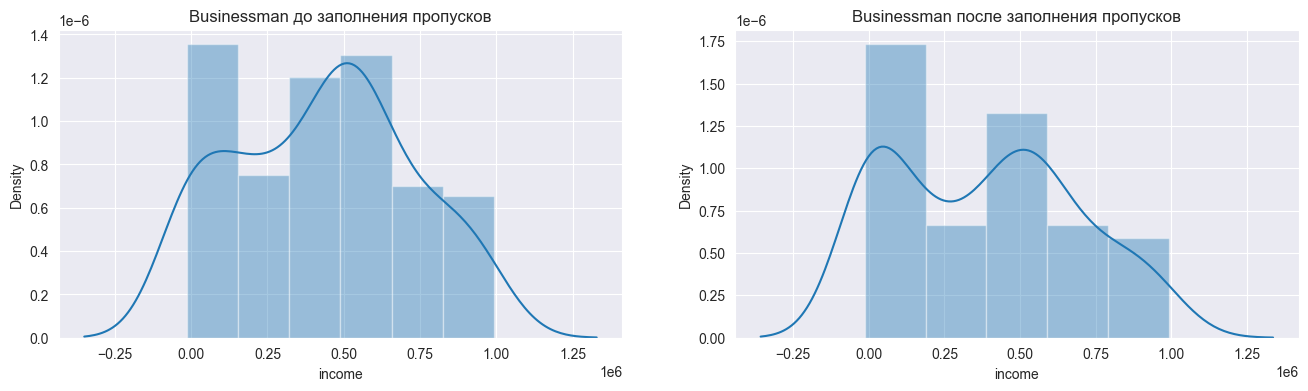

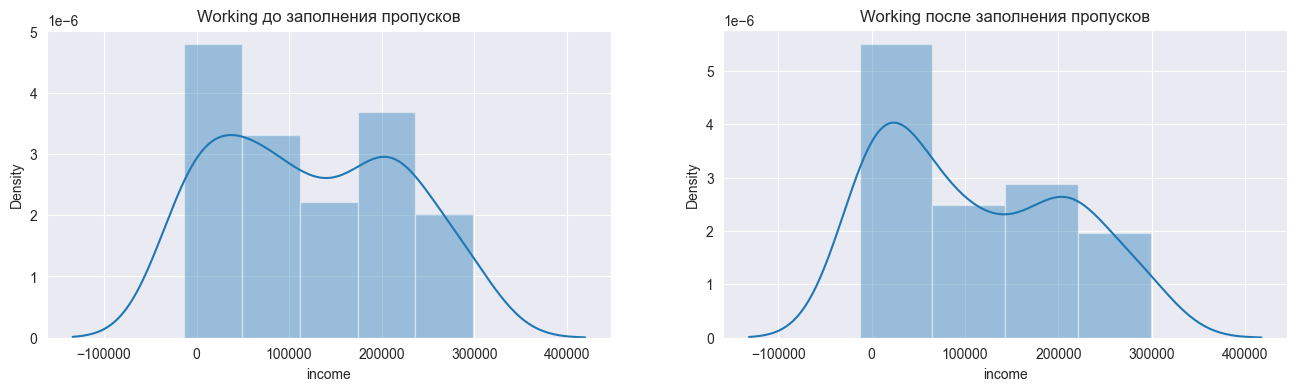

In [28]:
income_mean = df.groupby('status')['income'].mean()
status = ['Student', 'Pensioner', 'Businessman', 'Working']
for x in status:
    plot_feature_income(x)

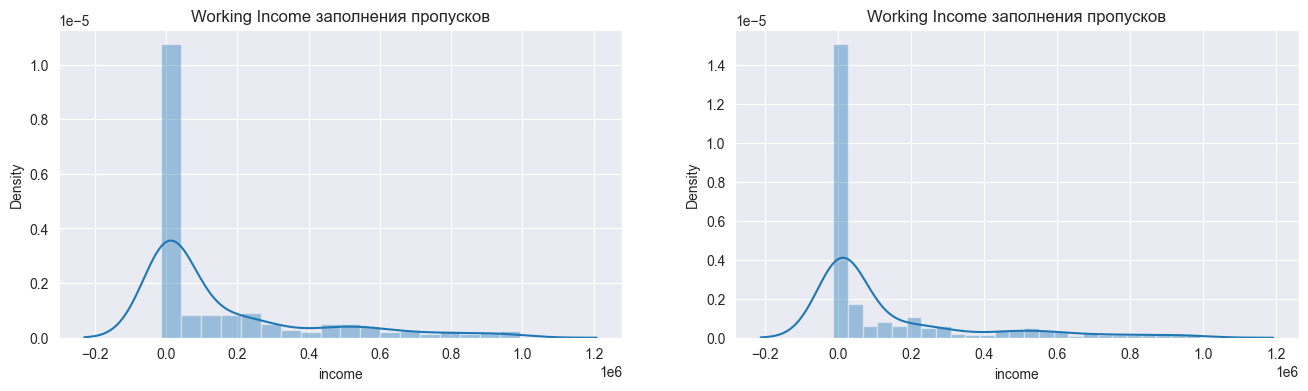

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plt.subplot(1, 2, 1);
plt.title(f'{x} Income заполнения пропусков')
sns.distplot(df_copy['income']);
plt.subplot(1, 2, 2)
sns.distplot(df['income']);
plt.title(f'{x} Income заполнения пропусков');

Распределение признака  по группам после заполнения пропусков местами отличается. Это связано лишь с малым количеством данных. При  большей выборки - ситуация была бы значительно лучше.   
Плотность распределения с пропусками и без  признака **income** имеет  небольшое отличие, но общая структура сохранена.

## age
Заполняем пропуски средним по статусу. Заменим и нулевой возраст

In [30]:
def plot_feature_age(x):
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    df_new = df.loc[(df['status'] == x) & (~df['age'].isnull())]
    plt.subplot(1, 2, 1);
    plt.title(f'{x} до заполнения пропусков')
    sns.distplot(df_new['age']);
    df.loc[((df['status'] == x) & (df['age'].isnull())), 'age'] = mean_age[x]
    df.loc[((df['status'] == x) & (df['age'] == 0)), 'age'] = mean_age[x]
    plt.subplot(1, 2, 2)
    sns.distplot(df.loc[df['status']==x, 'age']);
    plt.title(f'{x} после заполнения пропусков');

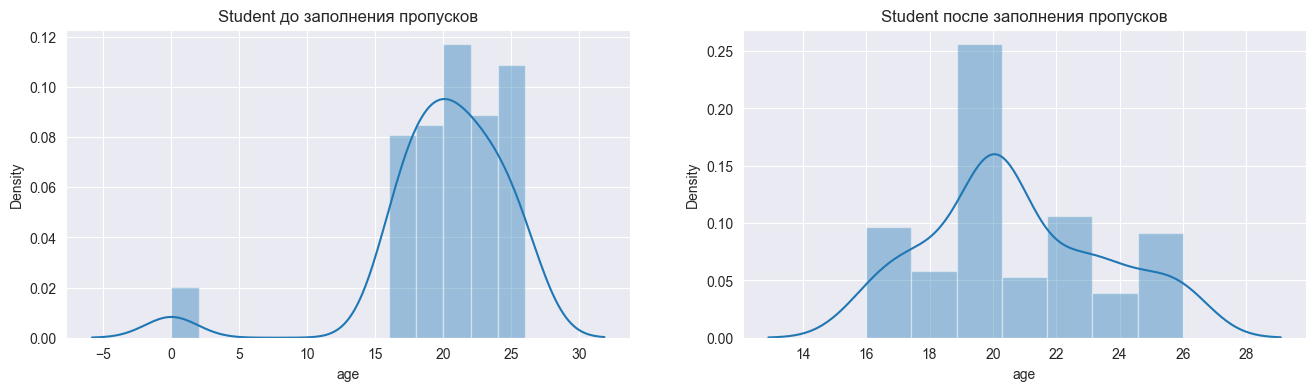

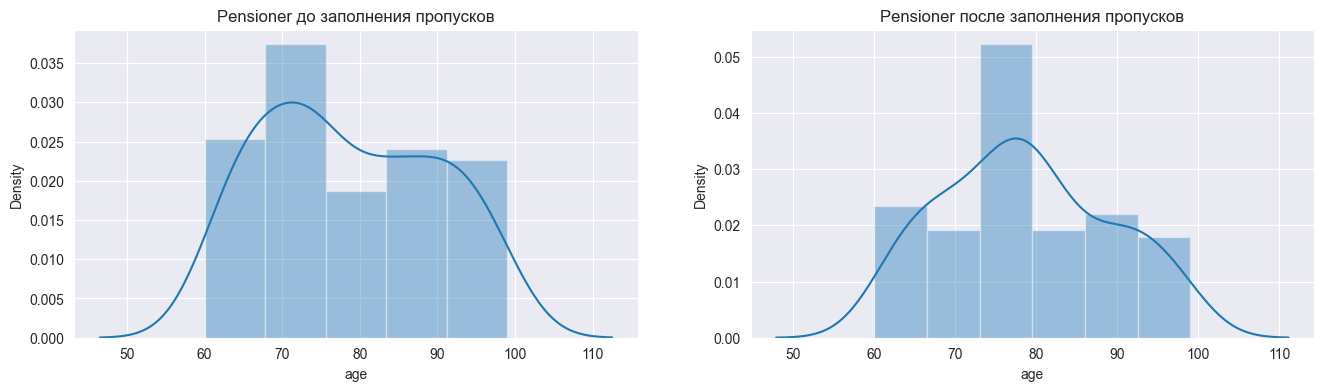

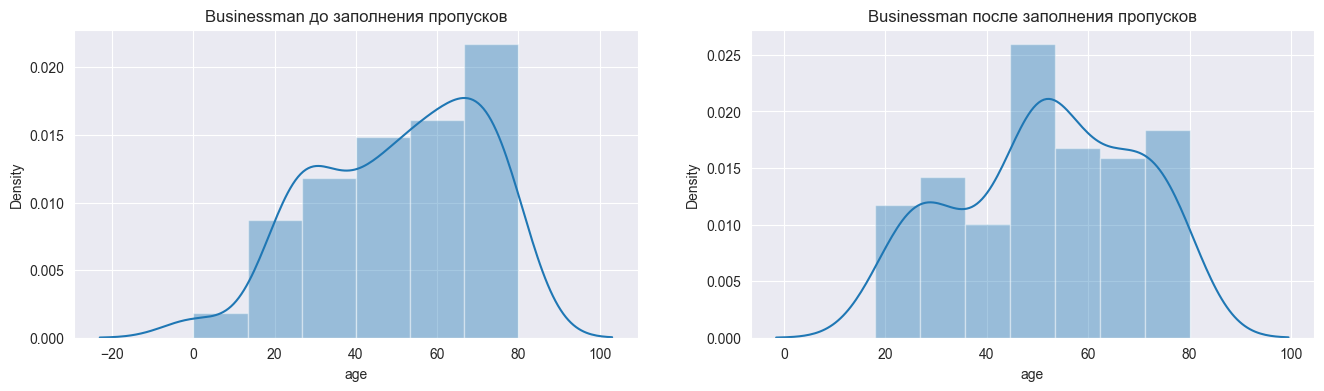

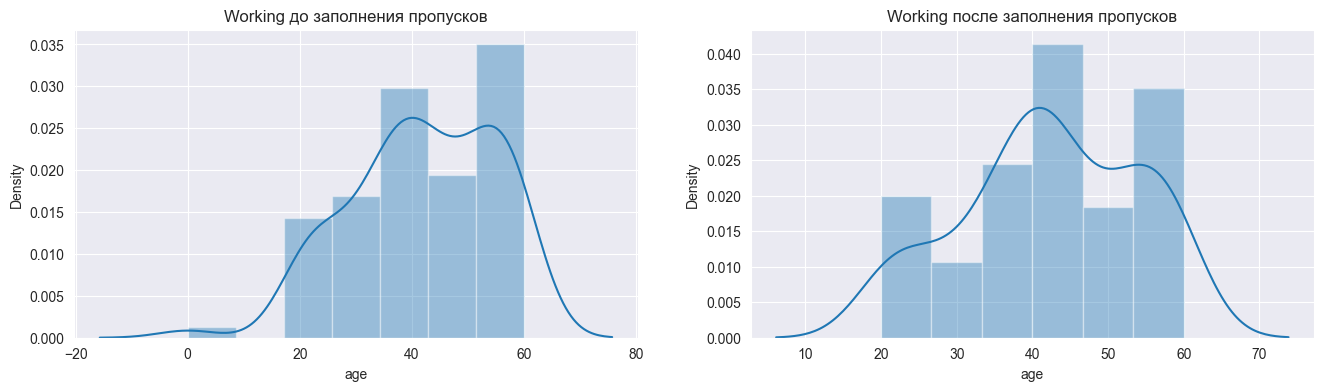

In [31]:
mean_age = df.groupby('status')['age'].mean()
for x in status:
    plot_feature_age(x)

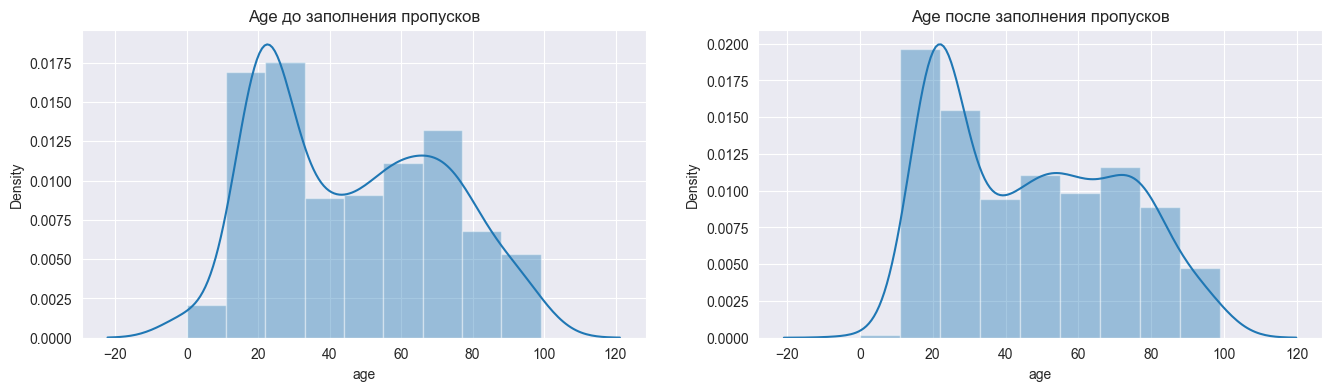

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plt.subplot(1, 2, 1);
plt.title('Age до заполнения пропусков')
sns.distplot(df_copy['age']);
plt.subplot(1, 2, 2)
sns.distplot(df['age']);
plt.title('Age после заполнения пропусков');

Ситуация аналогична признаку **income**. Плотность распределения с пропусками и без признака age имеет небольшое отличие, но общая структура сохранена.

Посмотрим, какие неопределённости ещё остались:

In [33]:
df.isna().any()

status     True
income     True
age       False
date      False
dtype: bool

In [34]:
display(df[df['status'].isnull()])

status    income   age       date
35     NaN  286000.0  53.0 2022-01-30
65     NaN       NaN  76.0 2022-01-10
83     NaN  262000.0  35.0 2022-01-19
169    NaN    9000.0  85.0 2022-01-19
197    NaN  169000.0  59.0 2022-01-17
359    NaN   30000.0   0.0 2022-01-05
376    NaN   -7248.0  81.0 2022-01-12
378    NaN       NaN  16.0 2022-01-22
382    NaN   79000.0  24.0 2022-01-22
468    NaN  691000.0  54.0 2022-01-10

Пропусков мало. Обойдемся без визуализации распределения признака

Меньше 18 лет - студент, больше 65 - пенсионер

In [35]:
df.loc[(df['status'].isnull() & (df['age'] <= 18)), 'status'] = 'Student'
df.loc[(df['status'].isnull() & (df['age'] >= 65)), 'status'] = 'Pensioner'

In [36]:
df[df['status'].isnull()]

status    income   age       date
35     NaN  286000.0  53.0 2022-01-30
83     NaN  262000.0  35.0 2022-01-19
197    NaN  169000.0  59.0 2022-01-17
382    NaN   79000.0  24.0 2022-01-22
468    NaN  691000.0  54.0 2022-01-10

Остальных определим в 'Working'. Только человека с доходом в 691000.0 в бизнесмесе( выше средней income среди бизнесменов)

In [37]:
df.loc[(df["status"].isnull() & (df["income"] == 691000.0)), "status"] = "Businessman"
df.loc[df["status"].isnull(), "status"] = "Working"

In [38]:
df.loc[(df['income'].isnull())]

status  income   age       date
65   Pensioner     NaN  76.0 2022-01-10
378    Student     NaN  16.0 2022-01-22

Определим студенту income = 0. А пенсионеру по среднему доходу его группы

In [39]:
df.loc[(df['income'].isnull() & (df['status'] == 'Pensioner')), 'income'] = income_mean['Pensioner']
df.loc[(df['income'].isnull() & (df['status'] == 'Student')), 'income'] = 0

In [40]:
# пропусков больше нет
df.loc[(df['income'].isnull())]

Empty DataFrame
Columns: [status, income, age, date]
Index: []